# PageRank
Adapted from: https://colab.research.google.com/github/AllenDowney/DSIRP/blob/main/notebooks/pagerank.ipynb

In [1]:
import urllib.request
data = urllib.request.urlopen("https://raw.githubusercontent.com/chandan-u/graph-based-recommendation-system/master/data/movies.csv").read()
with open("./movies.csv", "wb") as f:
  f.write(data)
data = urllib.request.urlopen("https://raw.githubusercontent.com/chandan-u/graph-based-recommendation-system/master/data/ratings.csv").read()
with open("./ratings.csv", "wb") as f:
  f.write(data)


In [2]:
import pandas as  pd
import numpy as np
import networkx as nx

def load_movielens():
    """
         load the three csv files:
             1. movies.csv: movieId,title,genres
             2. ratings.csv: userId,movieId,rating,timestamp
             3. tags.csv: userId,movieId,tag,timestamp   ( This is not needed for now)
    """
    movies = pd.read_csv('./movies.csv', sep=',')
    ratings = pd.read_csv('./ratings.csv', sep=',')
    return movies, ratings

def biparteGraph(movies_frame, ratings_frame):
    """
       convert the movies data frame into userid-movies biparte adjacency graph matrix
    """
    B = nx.Graph()
    user_ids = list(ratings_frame.userId.unique())
    movie_ids = list(movies_frame.movieId.unique())
    print("number of users:", len(user_ids))
    print("number of movies:", len(movie_ids))

    #B.add_nodes_from(user_ids, bipartite="user ids")
    #B.add_nodes_from(movie_ids, bipartite="movie ids")
    # initialize a numpy matrix of of numberOfUsers * numberOfMovies
    for name, group in ratings_frame.groupby(["userId", "movieId"]):
        # name is a tuple (userId, movieId)
        userId, movieId = name
        m = movies[movies.movieId == movieId].title
        title = m[m.index[0]]
        #rating = group[["rating"]].values[0,0]
        B.add_edge(f"user:{userId}", title)

    return B


# load csv into dataframes
movies, ratings  = load_movielens()
# convert the ratings datafrom into user-movie biparte graph
B = biparteGraph(movies, ratings)

number of users: 671
number of movies: 9125


In [3]:
B.number_of_edges(), B.number_of_nodes()

(100003, 9735)

In [4]:
list(B.nodes)[:20]

['user:1',
 'Dangerous Minds (1995)',
 'Dumbo (1941)',
 'Sleepers (1996)',
 'Escape from New York (1981)',
 'Cinema Paradiso (Nuovo cinema Paradiso) (1989)',
 'Deer Hunter, The (1978)',
 'Ben-Hur (1959)',
 'Gandhi (1982)',
 "Dracula (Bram Stoker's Dracula) (1992)",
 'Cape Fear (1991)',
 'Star Trek: The Motion Picture (1979)',
 'Beavis and Butt-Head Do America (1996)',
 'French Connection, The (1971)',
 'Tron (1982)',
 'Gods Must Be Crazy, The (1980)',
 'Willow (1988)',
 'Antz (1998)',
 'Fly, The (1986)',
 'Time Bandits (1981)']

In [5]:
B['user:262']

AtlasView({'Toy Story (1995)': {}, 'Jumanji (1995)': {}, 'Ace Ventura: When Nature Calls (1995)': {}, 'City of Lost Children, The (Cité des enfants perdus, La) (1995)': {}, 'Babe (1995)': {}, 'Clueless (1995)': {}, 'Seven (a.k.a. Se7en) (1995)': {}, 'From Dusk Till Dawn (1996)': {}, 'Hate (Haine, La) (1995)': {}, 'Braveheart (1995)': {}, 'Taxi Driver (1976)': {}, 'Beauty of the Day (Belle de jour) (1967)': {}, 'Kids (1995)': {}, 'Dumb & Dumber (Dumb and Dumber) (1994)': {}, 'Heavenly Creatures (1994)': {}, 'Interview with the Vampire: The Vampire Chronicles (1994)': {}, 'Natural Born Killers (1994)': {}, 'Léon: The Professional (a.k.a. The Professional) (Léon) (1994)': {}, 'Pulp Fiction (1994)': {}, 'Three Colors: Red (Trois couleurs: Rouge) (1994)': {}, 'Three Colors: Blue (Trois couleurs: Bleu) (1993)': {}, 'Shawshank Redemption, The (1994)': {}, 'Shallow Grave (1994)': {}, 'Ace Ventura: Pet Detective (1994)': {}, 'Bitter Moon (1992)': {}, 'Forrest Gump (1994)': {}, 'Four Weddings an

In [6]:
def get_node_neighbors_subgraph(G, node, frac=.1):
    neighbors = set(list(G.neighbors(node))[:int(frac*len(list(G.neighbors(node))))])
    neighbors_of_neighbors = set()
    for neighbor in neighbors:
        neighbors_of_neighbors.update(list(G.neighbors(neighbor))[:int(frac*len(list(G.neighbors(neighbor))))])

    # Combine the node, its neighbors, and their neighbors into a single set
    nodes_to_draw = neighbors  | {node} | neighbors_of_neighbors

    # Create a subgraph containing only the nodes of interest
    subgraph = G.subgraph(nodes_to_draw)

    return subgraph

Here's what the graph looks like. Multiple links appear as slightly thicker lines.

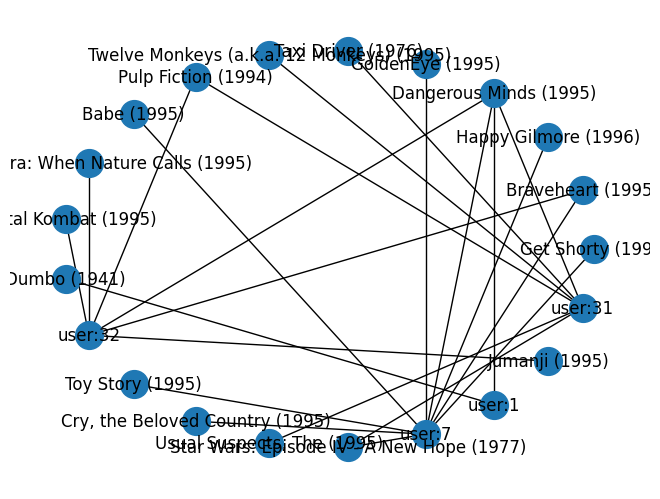

In [7]:
def draw_graph(G):
    nx.draw_circular(G, node_size=400, with_labels=True)

sub = get_node_neighbors_subgraph(B, 'Dangerous Minds (1995)', frac=.1)

draw_graph(sub)

[Note] Add by Hui Lin 04/08/2025

The more popular the movie, the thicker the sub-pictures will be.

NetworkX provides an implementation of PageRank we can use to compute a metric of "importance" for each page.

In [8]:
ranks_pr = nx.pagerank(B)
sorted(ranks_pr.items(), key=lambda x: -x[1])[:10]

[('user:547', 0.019686487233840862),
 ('user:624', 0.012712654175352927),
 ('user:564', 0.010500410058924225),
 ('user:73', 0.009318370110549118),
 ('user:15', 0.008984741244518472),
 ('user:468', 0.007248032226058771),
 ('user:452', 0.006901500779023015),
 ('user:311', 0.005500921986154309),
 ('user:380', 0.005485733047023199),
 ('user:30', 0.005401881837438508)]

You should see that nodes with more in-links get higher scores.

##  Random Walk

One way to interpret PageRank is in terms of a random walk.
Suppose you choose a node at random, then choose one of its out-links at random, and continue like that, making a note of each node you visit.

If a node has a lot of in-links, you are likely to visit it more often.
And if those in-links come from nodes with many in-links, even more so.

However, there is one catch: if a node contains no out-links, or if a set of nodes form a loop with no out-links, the random walker could get trapped.

To avoid that, we'll modify the random walk so at every step there is some probability that the walker jumps to a random node rather than following a link.
This probability is determined by a parameter, `alpha`, which is the probability of following a link, so `1-alpha` is the probability of making a random jump.

The following function implements a random walk, with these random jumps, and uses a `Counter` to keep track of the number of times it visits each node.

It returns the `Counter` with the frequencies normalized to add up to one.
If everything goes according to plan, these values should approximate the results from PageRank.

In [9]:
#--- define the function for fliping randomly
import numpy as np

def flip(p):
    return np.random.random() < p

In [10]:
#--- define the function for random walk
from collections import Counter

def random_walk(G, alpha=0.85, iters=1000000):
    counter = Counter()
    node = next(iter(G))

    for _ in range(iters):
        if flip(alpha):
            node = np.random.choice(list(G[node]))
        else:
            node = np.random.choice(list(G))

        counter[node] += 1

    total = sum(counter.values())
    for key in counter:
        counter[key] /= total
    return counter

The default value of `alpha` is 0.85, which is the same as the default value for `nx.pagerank`.

Here are the scores we get from the random walk.

In [11]:
ranks_rw = random_walk(B, iters=10000)
sorted(ranks_rw.items(), key=lambda x: -x[1])[:10]

[(np.str_('user:547'), 0.0218),
 (np.str_('user:624'), 0.0142),
 (np.str_('user:73'), 0.0085),
 (np.str_('user:564'), 0.0085),
 (np.str_('user:15'), 0.0083),
 (np.str_('user:452'), 0.0071),
 (np.str_('user:30'), 0.0064),
 (np.str_('user:380'), 0.0055),
 (np.str_('user:311'), 0.0053),
 (np.str_('user:213'), 0.0053)]

To compare them to the results from PageRank, put them in a Pandas `DataFrame`.

In [12]:
import pandas as pd

s1 = pd.Series(ranks_pr)
s2 = pd.Series(ranks_rw)

df = pd.DataFrame(dict(PageRank=s1, RandomWalk=s2))
df['Diff'] = df['RandomWalk'] - df['PageRank']
df*100

,PageRank,RandomWalk,Diff
"""Great Performances"" Cats (1998)",0.002524,NaN,NaN
$9.99 (2008),0.002963,NaN,NaN
'Hellboy': The Seeds of Creation (2004),0.001862,0.01,0.008138
'Neath the Arizona Skies (1934),0.002028,NaN,NaN
'Round Midnight (1986),0.002732,NaN,NaN
...,...,...,...
xXx (2002),0.011142,NaN,NaN
xXx: State of the Union (2005),0.001979,NaN,NaN
¡Three Amigos! (1986),0.014174,0.01,-0.004174
À nous la liberté (Freedom for Us) (1931),0.002040,NaN,NaN


Why some of the entries are `NaN`?, does it help if you increase the value of `iters`

In [13]:
# 1) why for `iters=10000` the RandomWalk value for some nodes is undefined?

### 1） Answer: by Hui Lin 04/08/2025
'''
Compared to the size of the overall graph,
if the step count is relatively small,
the random walker algorithm may not have enough chance to access certain nodes,
such as niche movies with fewer people comment.
In addition, if the structure of the graph is relatively complex
and there are isolated nodes or closed loop traps, more NaN values ​​will also appear.
'''


'\nCompared to the size of the overall graph,\nif the step count is relatively small,\nthe random walker algorithm may not have enough chance to access certain nodes,\nsuch as niche movies with fewer people comment.\nIn addition, if the structure of the graph is relatively complex\nand there are isolated nodes or closed loop traps, more NaN values \u200b\u200bwill also appear.\n'

In [14]:
# 2) If you want to measure the error rate between `PageRank` and `RandomWalk`,
# what would be a sensible formula for that? compute the error rate for:
# iters = 10000, 100000, 200000, 1000000

### 2) Answer:  by Hui Lin 04/08/2025
'''
To compare the difference between data vectors,
commonly used error measurement formulas include:
1. Mean Squared Error (MSE)
2. Mean Absolute Error (MAE)
3. Root Mean Squared Error (RMSE)
In comparison of probability distributions,
the MSE formula is usually used because it is more sensitive
to larger errors and is suitable for ranking or comparison of probability distributions.
'''




'\nTo compare the difference between data vectors,\ncommonly used error measurement formulas include:\n1. Mean Squared Error (MSE)\n2. Mean Absolute Error (MAE)\n3. Root Mean Squared Error (RMSE)\nIn comparison of probability distributions,\nthe MSE formula is usually used because it is more sensitive\nto larger errors and is suitable for ranking or comparison of probability distributions.\n'

In [15]:
import networkx as nx
import numpy as np
import pandas as pd
from collections import defaultdict


# compute RandomWalk for different iters
iters_list = [10000, 100000, 200000, 1000000]
mse_results = []

for iters in iters_list:
    ranks_rw = random_walk(B, iters=iters)

    #--- for the same node
    common_nodes = set(ranks_pr.keys()) & set(ranks_rw.keys())
    pr_values = np.array([ranks_pr[node] for node in common_nodes])
    rw_values = np.array([ranks_rw[node] for node in common_nodes])

    #--- calculate the MSE
    mse = np.mean((rw_values - pr_values) ** 2)
    mse_results.append(mse)

# output the result
df = pd.DataFrame({"Iterations": iters_list, "MSE": mse_results})
print(df)

   Iterations           MSE
0       10000  2.478575e-08
1      100000  1.024511e-09
2      200000  5.141034e-10
3     1000000  1.143160e-10


### test result for question 2)
From the running results, it can be seen that the error (MSE) of RandomWalk and PageRank significantly decreases with the increase of iterations, indicating that RandomWalk has good convergence, and when iters are large enough, RandomWalk's results will be very close to PageRank.

In [16]:
# 3) Explain how PageRank values should be interpreted in this context?

### 3) Answer:  by Hui Lin 04/08/2025
'''
Based on the understanding of the Page Rank equation mentioned in class,
the PageRank value is a normalized probability distribution,
representing the long-term probability of accessing a node
during an infinite number of random walks.
The higher the value, the more "important" or "center" the node is in the graph.
eg: Shawshank Redemption, The (1994)
So PageRank is the theoretical steady-state solution,
while RandomWalk approximates the calculation
through random walks with a finite number of steps (iters).
'''


'\nBased on the understanding of the Page Rank equation mentioned in class,\nthe PageRank value is a normalized probability distribution,\nrepresenting the long-term probability of accessing a node\nduring an infinite number of random walks.\nThe higher the value, the more "important" or "center" the node is in the graph.\neg: Shawshank Redemption, The (1994)\nSo PageRank is the theoretical steady-state solution,\nwhile RandomWalk approximates the calculation\nthrough random walks with a finite number of steps (iters).\n'

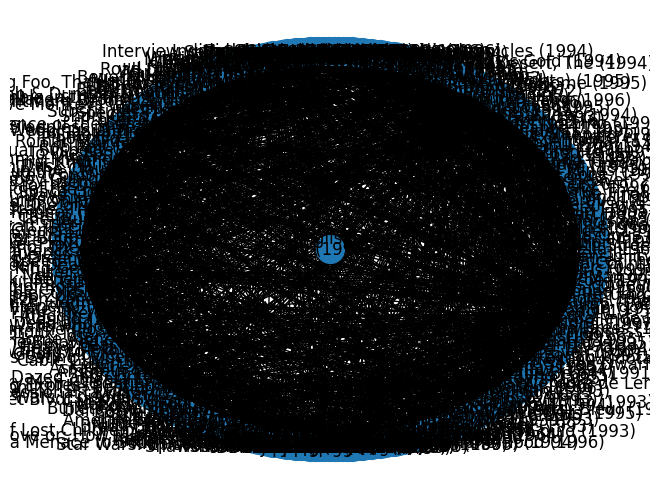

In [17]:
# 4) Look at top rank movies and users, and justify that your answer to
# the previous question makes sense.

### 4) Answer:  by Hui Lin 04/08/2025
'''
  It can be verified by the following sample.
'''
sub1 = get_node_neighbors_subgraph(B, 'Shawshank Redemption, The (1994)', frac=.1)
sub2 = get_node_neighbors_subgraph(B, 'Ed (1996)', frac=.1)

draw_graph(sub1)
draw_graph(sub2)

In [ ]:
#def random_walk_with_teleport_S(G, alpha=0.85, iters=1000000, S=None):
# 5) implement the random walk with a teleport S. Use it to find
# similar movies to your favorite set of movies.
#  pass



In [29]:
### 5) Answer by Hui Lin 04/09/2025

import pandas as pd
import numpy as np
import networkx as nx
from collections import Counter

def random_walk_with_teleport_S(G, alpha=0.85, iters=1000000, S=None):
    counter = Counter()
    node = next(iter(G))

    for _ in range(iters):
        if flip(alpha):
            node = np.random.choice(list(G[node]))
        else:
            if S is not None and len(S) > 0:
                node = np.random.choice(list(S))
            else:
                node = np.random.choice(list(G))

        counter[node] += 1

    total = sum(counter.values())
    for key in counter:
        counter[key] /= total
    return counter

#--- set input parameter
my_favorite = ['Shawshank Redemption, The (1994)']
#--- call the function
ranks_rw_with_teleport = random_walk_with_teleport_S(B, iters=10000, S=my_favorite)

#--- output the result: Top 5 similar movies
sorted_ranks = sorted(ranks_rw_with_teleport.items(), key=lambda x: -x[1])
similar_movies = [node for node, _ in sorted_ranks if not node.startswith('user:') and node not in favorite_movies][:5]
print("Top 5 Similar movies:", similar_movies)

Top 5 Similar movies: [np.str_('Silence of the Lambs, The (1991)'), np.str_('Pulp Fiction (1994)'), np.str_('Aladdin (1992)'), np.str_('Saving Private Ryan (1998)'), np.str_('Gladiator (2000)')]


In [ ]:
# 6) biparteGraph function only uses the existence of a
#    rating to establish a link. Change it so that it uses the rating
#    as the weight of the edge.

In [28]:
### 6) Answer by Hui Lin 04/09/2025

import pandas as pd
import numpy as np
import networkx as nx
from collections import Counter

def biparteGraph2(movies_frame, ratings_frame):
    """
       convert the movies data frame into userid-movies bipartite adjacency graph matrix
       Use the rating as the weight of the edge.
    """
    B = nx.Graph()
    user_ids = list(ratings_frame.userId.unique())
    movie_ids = list(movies_frame.movieId.unique())
    print("number of users:", len(user_ids))
    print("number of movies:", len(movie_ids))

    for name, group in ratings_frame.groupby(["userId", "movieId"]):
        userId, movieId = name
        m = movies_frame[movies_frame.movieId == movieId].title
        title = m[m.index[0]]
        rating = group[["rating"]].values[0, 0]
        B.add_edge(f"user:{userId}", title, weight=rating)

    return B


def random_walk2(G, alpha=0.85, iters=1000000):
    counter = Counter()
    node = next(iter(G))

    for _ in range(iters):
        if flip(alpha):
            neighbors = list(G[node])
            weights = [G[node][neighbor]['weight'] for neighbor in neighbors]
            total_weight = sum(weights)
            probabilities = [weight / total_weight for weight in weights]
            node = np.random.choice(neighbors, p=probabilities)
        else:
            node = np.random.choice(list(G))

        counter[node] += 1

    total = sum(counter.values())
    for key in counter:
        counter[key] /= total
    return counter

# convert the ratings datafrom into user-movie bipartite graph with weights
NB = biparteGraph2(movies, ratings)

# Perform PageRank
ranks_pr2 = nx.pagerank(NB)

# Perform random walk
ranks_rw2 = random_walk2(NB, iters=10000)

print("PageRank results:", sorted(ranks_pr2.items(), key=lambda x: -x[1])[:10])
print("Random walk results:", sorted(ranks_rw2.items(), key=lambda x: -x[1])[:10])


number of users: 671
number of movies: 9125
PageRank results: [('user:547', 0.019056431808977547), ('user:624', 0.01131392568190867), ('user:564', 0.010775797055188965), ('user:73', 0.009116408422442922), ('user:15', 0.007016076452153033), ('user:468', 0.006437551710232732), ('user:452', 0.006296781277490164), ('user:30', 0.005731581299697041), ('user:380', 0.005319261421817361), ('user:294', 0.005265649148778596)]
Random walk results: [(np.str_('user:547'), 0.0188), (np.str_('user:624'), 0.0117), (np.str_('user:564'), 0.0109), (np.str_('user:73'), 0.0101), (np.str_('user:15'), 0.0079), (np.str_('user:294'), 0.0067), (np.str_('user:452'), 0.0066), (np.str_('user:468'), 0.0065), (np.str_('user:30'), 0.0056), (np.str_('user:311'), 0.0052)]


In [ ]:
def weighted_random_walk_with_teleport_S(G, alpha=0.85, iters=1000000, S=None):
# 7) the current implementation of random walk only relies on the existence of a
#    rating and ignores the value. Use the value to implement
#.   a weighted version of the random walk. Use the weighted version
#    to find similar movies and compare the results.
  pass

In [30]:
### 7) Answer by Hui Lin 04/09/2025

import pandas as pd
import numpy as np
import networkx as nx
from collections import Counter


def weighted_random_walk_with_teleport_S(G, alpha=0.85, iters=1000000, S=None):
    counter = Counter()
    node = next(iter(G))

    for _ in range(iters):
        if flip(alpha):
            neighbors = list(G[node])
            if neighbors:
                weights = [G[node][neighbor].get('weight', 1) for neighbor in neighbors]
                total_weight = sum(weights)
                if total_weight > 0:
                    probabilities = [weight / total_weight for weight in weights]
                    node = np.random.choice(neighbors, p=probabilities)
                else:
                    node = np.random.choice(neighbors)
        else:
            if S is not None and len(S) > 0:
                node = np.random.choice(list(S))
            else:
                node = np.random.choice(list(G))

        counter[node] += 1

    total = sum(counter.values())
    for key in counter:
        counter[key] /= total
    return counter


#--- set input parameter
my_favorite = ['Shawshank Redemption, The (1994)']
#--- call the function
ranks_weighted_rw = weighted_random_walk_with_teleport_S(NB, iters=10000, S=my_favorite)

#--- output the result: Top 5 similar movies
sorted_weighted_ranks = sorted(ranks_weighted_rw.items(), key=lambda x: -x[1])
similar_movies_weighted = [node for node, _ in sorted_weighted_ranks if not node.startswith('user:') and node not in my_favorite][:5]
print("Top 5 Similar movies (with weighted version):", similar_movies_weighted)


Top 5 Similar movies (with weighted version): [np.str_('Pulp Fiction (1994)'), np.str_('Forrest Gump (1994)'), np.str_('Silence of the Lambs, The (1991)'), np.str_("Schindler's List (1993)"), np.str_('Saving Private Ryan (1998)')]


### Using Pyspark to re-implement the code

In [33]:
import os
os.environ['PYTHONHASHSEED'] = '0'

from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import random
from collections import Counter

#--- set up SparkSession
spark = SparkSession.builder \
    .appName("MovieGraphAnalysis") \
    .getOrCreate()

def load_movielens():
    movies = spark.read.csv('./movies.csv', header=True, inferSchema=True)
    ratings = spark.read.csv('./ratings.csv', header=True, inferSchema=True)
    return movies, ratings

def biparteGraph2(movies_frame, ratings_frame):
    edges = ratings_frame.join(movies_frame, on='movieId') \
        .select(col('userId').alias('src'), col('title').alias('dst'), col('rating').alias('weight'))
    # 缓存边数据
    edges = edges.cache()
    return edges

def random_walk2(edges_df, alpha=0.85, iters=1000000):
    grouped_edges = edges_df.rdd.groupBy(lambda row: row[0]).cache()
    counter = Counter()
    all_nodes = grouped_edges.flatMap(lambda x: [x[0]] + [neighbor[1] for neighbor in x[1]]).distinct().collect()
    node = random.choice(all_nodes)

    for _ in range(iters):
        if random.random() < alpha:
            neighbors = grouped_edges.lookup(node)
            if neighbors:
                neighbor_nodes = [row[1] for row in neighbors[0]]
                weights = [row[2] for row in neighbors[0]]
                total_weight = sum(weights)
                if total_weight > 0:
                    probabilities = [weight / total_weight for weight in weights]
                    node = random.choices(neighbor_nodes, weights=probabilities)[0]
                else:
                    node = random.choice(neighbor_nodes)
        else:
            node = random.choice(all_nodes)

        counter[node] += 1

    total = sum(counter.values())
    for key in counter:
        counter[key] /= total

    grouped_edges.unpersist()
    return counter

def weighted_random_walk_with_teleport_S(edges_df, alpha=0.85, iters=1000000, S=None):
    grouped_edges = edges_df.rdd.groupBy(lambda row: row[0]).cache()
    counter = Counter()
    all_nodes = grouped_edges.flatMap(lambda x: [x[0]] + [neighbor[1] for neighbor in x[1]]).distinct().collect()
    node = random.choice(all_nodes)

    for _ in range(iters):
        if random.random() < alpha:
            neighbors = grouped_edges.lookup(node)
            if neighbors:
                neighbor_nodes = [row[1] for row in neighbors[0]]
                weights = [row[2] for row in neighbors[0]]
                total_weight = sum(weights)
                if total_weight > 0:
                    probabilities = [weight / total_weight for weight in weights]
                    node = random.choices(neighbor_nodes, weights=probabilities)[0]
                else:
                    node = random.choice(neighbor_nodes)
        else:
            if S is not None and len(S) > 0:
                node = random.choice(S)
            else:
                node = random.choice(all_nodes)

        counter[node] += 1

    total = sum(counter.values())
    for key in counter:
        counter[key] /= total

    grouped_edges.unpersist()
    return counter

#--- load data
movies, ratings = load_movielens()
#--- build the graph
NB = biparteGraph2(movies, ratings)

# from graphframes import GraphFrame
# g = GraphFrame(vertices, edges)
# ranks = g.pageRank(resetProbability=0.15, maxIter=10)

#--- run the random walk function
ranks_rw2 = random_walk2(NB, iters=10000)

#--- output the result
print("Random walk results:", sorted(ranks_rw2.items(), key=lambda x: -x[1])[:10])

#--- set input parameter
my_favorite = ['Shawshank Redemption, The (1994)']
#--- call the function
ranks_weighted_rw = weighted_random_walk_with_teleport_S(NB, iters=10000, S=my_favorite)

#--- output the result
sorted_weighted_ranks = sorted(ranks_weighted_rw.items(), key=lambda x: -x[1])
similar_movies_weighted = [node for node, _ in sorted_weighted_ranks if not str(node).startswith('user:') and node not in my_favorite][:5]
print("Top 5 Similar movies (with weighted version):", similar_movies_weighted)

NB.unpersist()

spark.stop()


Random walk results: [('Mr. Magoo (1997)', 0.0043), ('State of Play (2009)', 0.0038), ('Green Zone (2010)', 0.0038), ('Safe Haven (2013)', 0.0037), ('Hot Fuzz (2007)', 0.0036), ('Return, The (Vozvrashcheniye) (2003)', 0.0036), ('Millennium Actress (Sennen joyû) (2001)', 0.0036), ('Devil Wears Prada, The (2006)', 0.0034), ('Blue Umbrella, The (2013)', 0.0034), ('Hero (Ying xiong) (2002)', 0.0033)]
Top 5 Similar movies (with weighted version): ['Speed 2: Cruise Control (1997)']


### Report for Assignmnt 8

This assignment focuses on the application of several key concepts: movie data  loading, graph construction, and random walk algorithms.

The construction of a bipartite graph using the "biparteGraph" function is basical. By representing users and movies as nodes and ratings as edge weights in the "biparteGraph2" function, it models the relationship between them, demonstrating graph-based data representation, an important concept in handling complex data structures.

The PageRank and random walk algorithms are applied. PageRank calculates the importance of nodes in a graph, which is widely used in web search engines and other applications. The random walk algorithms, both the basic and weighted versions with teleport, simulate the traversal of the graph. They are used to find similar movies.

Comparing the results of different algorithms shows how different approaches can lead to diverse sets of similar movies, highlighting the significance of algorithm selection in data analysis.

Overall, these operations showcase data preprocessing, graph-based data handling, and algorithmic analysis in the context of big data.